# UBC Scientific Software Seminar

## October 21, 2016

Today's Agenda:

* Visualizing the hand-written digits dataset using dimensionality reduction and principal component analysis
  * Lodaing the digits dataset
  * Instantiate a PCA object and compute principal components
  * Visualizing the digits dataset
  * A closer look: when is a 5 equal to 8?
* Linear algebra behind principal component analysis
  * Find the eigenvectors of the matrix $X^T X$ where $X$ is the normalized data matrix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Visualizing the hand-written digits dataset using dimensionality reduction

The hand-written digits dataset is included as a builtin dataset in sklearn. Each sample is an 8 by 8 pixel image of a handwritten digit. We represent each image as a vector in 64-dimensional space. Our goal today is to project that 64-dimensional space of digits down to 2D while preserving as much of the variance in the data as possible.

#### Load the digits dataset

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()

In [4]:
digits.data.shape

(1797, 64)

In [5]:
digits.images.shape

(1797, 8, 8)

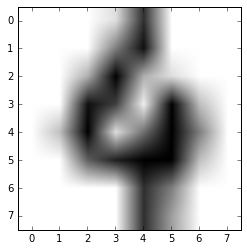

In [6]:
plt.imshow(digits.images[100,:,:],cmap='binary')

#### Instantiate a PCA object

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) projects the data onto orthogonal components in the feature space so that each component captures the maximum amount of variance. We'll apply PCA to the digits dataset and observe the results and then we'll do the computation for ourselves to see what's going on under the hood.

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=2) # We want 2 principal components so that we can plot the dataset in 2D

#### Compute the principal components

In [9]:
pca.fit(digits.data)

PCA(copy=True, n_components=2, whiten=False)

The model has computed the 2 principal components. What are they? They are vectors in the feature space. In other words, they are 8 by 8 pixel images. What do they look like? We can access the components using the `.components_` attribute.

In [10]:
pca.components_.shape

(2, 64)

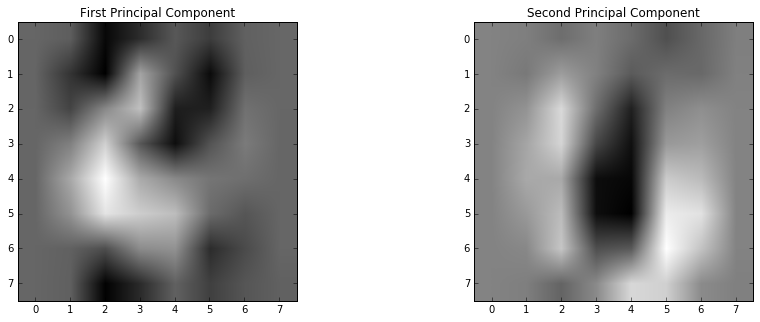

In [11]:
p1 = pca.components_[0,:] # First principal component
p2 = pca.components_[1,:] # Second principal component
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(p1.reshape(8,8),cmap='binary'), plt.title('First Principal Component')
plt.subplot(1,2,2)
plt.imshow(p2.reshape(8,8),cmap='binary'), plt.title('Second Principal Component');

This means that our PCA object is now equipped to project each image onto these two principal components. Looking at the 2 principal components, we can see that the best 2D representation of the dataset is the result of how much a digits looks like a 3 and how much it looks like a 0.

#### Visualizing the digits dataset

Now we can apply the `.transform` method to whole dataset and plot the result.

In [12]:
digits_2D = pca.transform(digits.data)

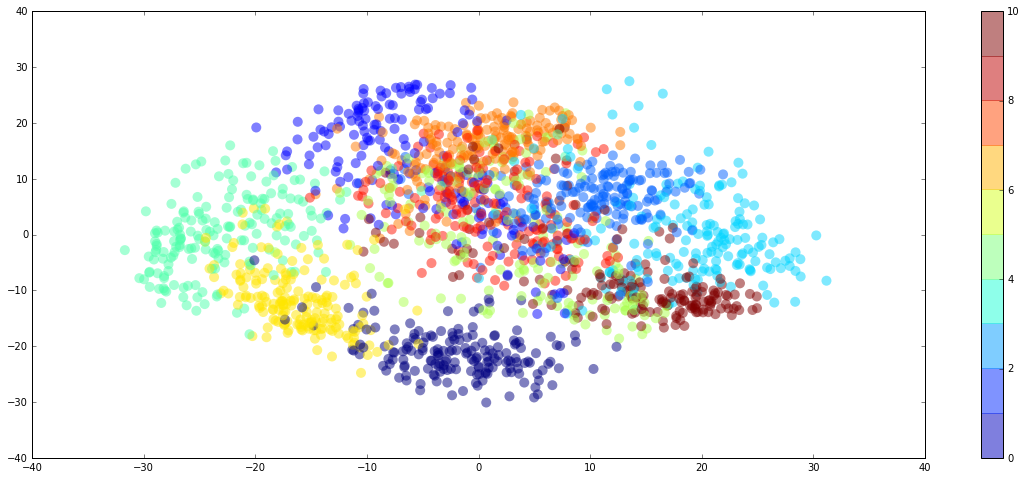

In [13]:
plt.figure(figsize=(20,8))
plt.scatter(digits_2D[:,0],digits_2D[:,1],c=digits.target,s=100,alpha=0.5,lw=0);
plt.colorbar(boundaries=range(0,11));

Notice how all the 3s are to the left along the horizontal axis. This is because the first principal component is a 3 **except with the colors inverted**. Similarly, the 0s are at the bottom along the vertical axis because the second principal component is a 0 **again with the colors inverted**. 

#### When is 5 equal to 8?

Let's apply PCA to the set of 5s and 8s to see how much they are separated in the feature space.

In [14]:
fives = digits.data[digits.target == 5]
eights = digits.data[digits.target == 8]

In [15]:
pca2 = PCA(n_components=2) # Instantiate a new PCA model with 2 components

In [16]:
fives_eights = np.vstack((fives,eights)) # Collect all the 5s and 8s in a single array
fives_eights_2D = pca2.fit_transform(fives_eights) # Fit and transform the 5s and 8s into 2D

In [17]:
fives_eights_targets = np.array([0 for _ in fives] + [1 for _ in eights]) # Hack together the array of labels for 5s and 8s

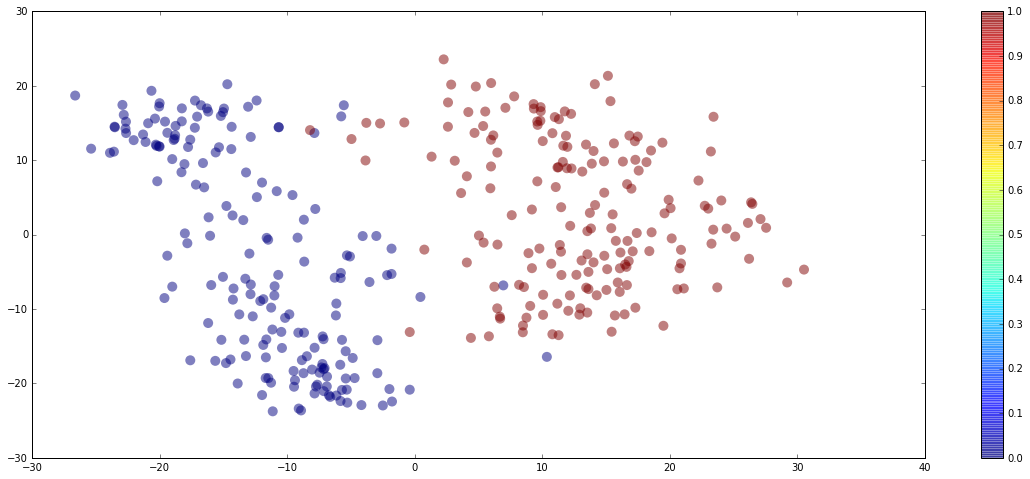

In [18]:
plt.figure(figsize=(20,8))
plt.scatter(fives_eights_2D[:,0],fives_eights_2D[:,1],c=fives_eights_targets,s=100,alpha=0.5,lw=0);
plt.colorbar();

### Linear algebra behind principal component analysis

The idea behind [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) is to find the vectors in the feature space which captures the most variance in the data:

![PCA](https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg)

#### Step 1: Normalize the data

The first step in the computation is to normalize the features so that they all have mean 0.

In [19]:
X = np.matrix(digits.data) - np.mean(digits.data,axis=0)

#### Step 2: Maximize the variance with eigenvectors (corresponding to maximum eigenvalues)

We want to project the data onto a single vector $w$. If our dataset $X$ consists of $n$ rows (ie. $n$ samples) and $p$ columns (ie. $p$ features), then the **sum of the squares of the norms of the projections of the samples onto a unit (column) vector $w$ (of length $p$) is** simply:

$$
|| X w ||^2 = w^T X^T X w
$$

Therefore we want to maximize the quantity:

$$
w^T X^T X w
$$

for a unit vector $w$. Since $X^TX$ is a symmetric matrix, this is a classical [result](https://en.wikipedia.org/wiki/Min-max_theorem): **the maximum value occurs when $w$ is the (unit) eigenvector of $X^TX$ with maximum eigenvalue**.

#### Step 3: Compute eigenvectors and plot the principal components

Let's find the 2 eigenvectors of $X^TX$ with 2 largest eigenvalues:

In [20]:
A = X.T * X

In [21]:
evals, evecs = np.linalg.eig(A)

The eigenvectors are returned in order from highest to lowest eigenvalue. Let's plot the 2 principal components and compare to the result from sklearn's PCA object.

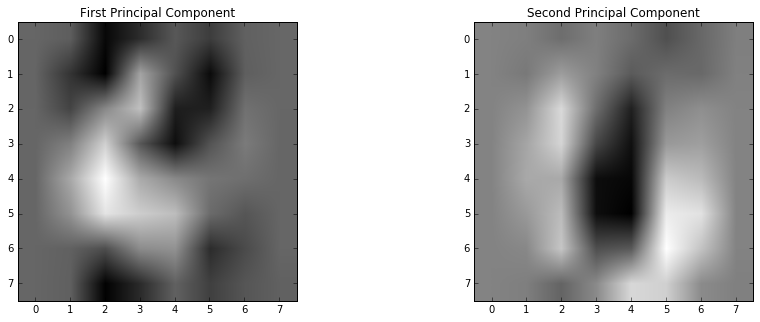

In [22]:
P1 = evecs[:,0]
P2 = evecs[:,1]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(P1.reshape(8,8),cmap='binary'), plt.title('First Principal Component')
plt.subplot(1,2,2)
plt.imshow(P2.reshape(8,8),cmap='binary'), plt.title('Second Principal Component');

These images are identical to the principal components computed by sklearn's PCA object above! In fact, we can compute the distance between these principal components and the principal components computed above:

In [23]:
np.linalg.norm(P1 - p1.reshape(64,1))

7.475742379099411e-15

In [24]:
np.linalg.norm(P2 - p2.reshape(64,1))

7.3930955456750324e-15